In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# eWaterCycle packages
import ewatercycle
from forcing import HBVForcing
from ewatercycle.base.forcing import GenericLumpedForcing

In [3]:
from model import HBV

Important  to set paths well:

In [4]:
shape = Path(ewatercycle.__file__).parent / "testing/data/Rhine/Rhine.shp"
path = Path.cwd()
forcing_path = path / "Forcing"

specify dates

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

setup forcing

In [6]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'Forcing.txt',
                          test_data_bool = True
                          )

In [7]:
model = HBV(forcing=test_forcing)

parameter information

In [8]:
s_0 = np.array([0,  100,  0,  5])
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
par_0 = (p_min_initial + p_max_initial)/2

In [9]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [10]:
model.initialize(config_file)

In [11]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [12]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

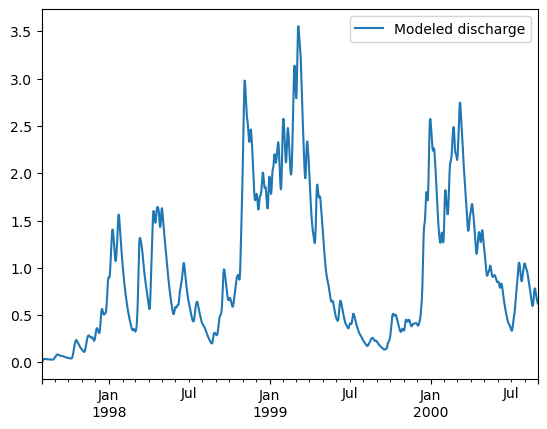

In [13]:
fig, ax = plt.subplots(1,1)
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.legend(bbox_to_anchor=(1,1));

In [ ]:
model.finalize()